# Fine-tuning Transformers, Airline Tweets Sentiment Analysis

The intent of this project is to highlight the performance of a fine-tuned Transformer (BERT) model versus traditional ML and LSTM models.

I will be comparing distilbert-base-cased from Huggingface's suite of models against the performance of models tested here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7514423/

In [ ]:
!pip install transformers datasets

In [ ]:
!pip install accelerate -U

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from datasets import load_dataset
import seaborn as sns

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Loading and preprocessing

In [ ]:
df = pd.read_csv("AirlineTweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df = df.loc[:, ['airline_sentiment', "text"]]
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


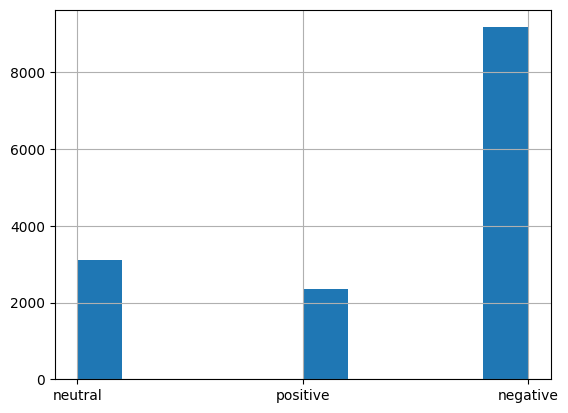

In [ ]:
# Imbalanced dataset
df['airline_sentiment'].hist();

In [ ]:
# Change labels to integers, which is required for model
target_map = {"positive":1, "neutral": 0, "negative": 2}
df['label'] = df["airline_sentiment"].map(target_map)

# Targets must have the column name 'label'

In [ ]:
df = df.rename(columns={"text": "sentence"})
df = df.loc[:,['sentence', 'label']]
df.head()

,sentence,label
0,@VirginAmerica What @dhepburn said.,0
1,@VirginAmerica plus you've added commercials t...,1
2,@VirginAmerica I didn't today... Must mean I n...,0
3,@VirginAmerica it's really aggressive to blast...,2
4,@VirginAmerica and it's a really big bad thing...,2


In [ ]:
# Save dataframe to make use of the load_dataset class
df.to_csv("data.csv", index=None)

In [ ]:
!head data.csv

sentence,label
@VirginAmerica What @dhepburn said.,0
@VirginAmerica plus you've added commercials to the experience... tacky.,1
@VirginAmerica I didn't today... Must mean I need to take another trip!,0
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",2
@VirginAmerica and it's a really big bad thing about it,2
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",2
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",0


In [ ]:
raw_data = load_dataset("csv", data_files='data.csv')
raw_data

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [ ]:
split = raw_data['train'].train_test_split(test_size=0.2, seed=42)
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 11712
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2928
    })
})

# Specifying model architecture and training strategy

In [ ]:
from transformers import AutoTokenizer

In [ ]:
# https://huggingface.co/docs/transformers/tasks/sequence_classification
# https://huggingface.co/distilbert-base-uncased

checkpoint = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
# Need to wrap truncation in a function for Trainer object.
# Note that padding is handled automatically by Trainer too.

def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation=True)

In [ ]:
tokenized_data = split.map(tokenize_fn, batched=True)
tokenized_data

Map:   0%|          | 0/11712 [00:00<?, ? examples/s]

Map:   0%|          | 0/2928 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 11712
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2928
    })
})

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoConfig, Trainer, TrainingArguments

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Specify training args
# Save checkpoints at each epoch

training_args = TrainingArguments(
  output_dir='training_dir',
  evaluation_strategy='epoch',
  save_strategy='epoch',
  num_train_epochs=3,
  per_device_train_batch_size=16,
  per_device_eval_batch_size=64,
)

In [ ]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average='macro')
  return {'accuracy': acc, 'f1': f1}

In [ ]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.537700,0.445335,0.822746,0.770564
2,0.374900,0.476133,0.834699,0.784732
3,0.163700,0.623289,0.841189,0.789827


TrainOutput(global_step=2196, training_loss=0.3227334847650024, metrics={'train_runtime': 202.8682, 'train_samples_per_second': 173.196, 'train_steps_per_second': 10.825, 'total_flos': 444253902314112.0, 'train_loss': 0.3227334847650024, 'epoch': 3.0})

# Saving best model and making predictions

In [ ]:
!ls training_dir

checkpoint-1464  checkpoint-2196  checkpoint-732  runs


In [ ]:
from transformers import pipeline

In [ ]:
savedmodel = pipeline('text-classification',
                      model='training_dir/checkpoint-732',
                      device=0)

In [ ]:
s = split['test']['sentence'][78]
print(s)
savedmodel(s)

@united screws up again...to be expected! NEVER AGAIN!


[{'label': 'LABEL_2', 'score': 0.9625450372695923}]

In [ ]:
# Possibly sarcastic
s = split['test']['sentence'][44]
print(s)
savedmodel(s)

@SouthwestAir Don't worry, you will! :-)


[{'label': 'LABEL_1', 'score': 0.8690521121025085}]

In [ ]:
s = split['test']['sentence'][10]
print(s)
savedmodel(s)

@united A change fee of $200. Same exact flight from ATL-HOU is $165. Why a charge of $574? The math doesn't add up.


[{'label': 'LABEL_2', 'score': 0.767566442489624}]

In [ ]:
s = split['test']['sentence'][8]
print(s)
savedmodel(s)

@SouthwestAir Deborah helped me💁


[{'label': 'LABEL_0', 'score': 0.6454923748970032}]

In [ ]:
texts = split['test']['sentence']
preds = savedmodel(texts)

In [ ]:
preds = np.array([int(x['label'][-1]) for x in preds])

In [ ]:
cm = confusion_matrix(split['test']['label'], preds, normalize='true')

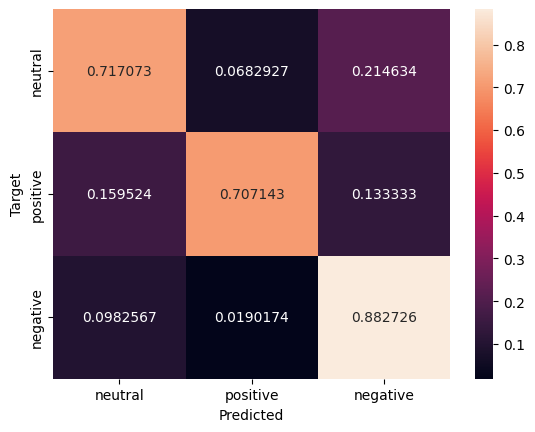

In [ ]:
def plot_cm(cm):
  classes = ["neutral", "positive", "negative"]
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

plot_cm(cm)

In [ ]:
f1_score(split['test']['label'], preds, average='macro')

0.7705638498199002

In [ ]:
accuracy_score(split['test']['label'], preds)

0.8227459016393442

# Conclusions

As seen, the BERT model outperforms all of the models tested in the research paper. It achieves an accuracy of 0.841 and performs well on all classes. The best performing model in the paper was a Voting Classifier (LR + SGDC) using TF-IDF, with an accuracy of 0.791.

Furthermore, the ease of Huggingface interface makes it easy to achieve state-of-the-art performance with minimal processing of the data and hyerparameter tuning.